In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

In [4]:
df_2004 = pd.read_stata('usu_individual_T104.dta', convert_categoricals=False)
df_2024 = pd.read_excel('usu_individual_T124.xlsx')

df_2004.columns = df_2004.columns.str.upper()
df_2024.columns = df_2024.columns.str.upper()
columnas_comunes = df_2004.columns.intersection(df_2024.columns)

df_2004_filtrado = df_2004[columnas_comunes]
df_2024_filtrado = df_2024[columnas_comunes]
df_combinado = pd.concat([df_2004_filtrado, df_2024_filtrado], ignore_index=True)

df_eph_nea = df_combinado[df_combinado['REGION'] == 41].copy()

# Variable EDAD2
if 'CH06' in df_eph_nea.columns:
    df_eph_nea['EDAD2'] = np.square(df_eph_nea['CH06'])
    print("Variable 'edad2' añadida exitosamente.")
else:
    print("No se encontró la columna 'CH06'.")

# Variable EDUC
def calcular_educ(row):
    if row['CH10'] == 1:
        if row['CH14'] in [98, 99]:
            return 6
        if row['CH12'] == 1:
            return 0
        elif row['CH12'] == 2:
            return row['CH14']
        elif row['CH12'] == 3:
            return row['CH14']
        elif row['CH12'] == 4:
            return 6 + row['CH14']
        elif row['CH12'] == 5:
            return 9 + row['CH14']
        elif row['CH12'] == 6:
            return 12 + row['CH14']
        elif row['CH12'] == 7:
            return 12 + row['CH14']
        elif row['CH12'] == 8:
            return 17 + row['CH14']
        elif row['CH12'] == 9:
            return row['CH14']
        else:
            return 0
    elif row['CH10'] == 2:
        if row['CH13'] == 1:
            if row['CH14'] in [98, 99]:
                return 6
            elif row['CH12'] == 1:
                return 0
            elif row['CH12'] == 2:
                return 6
            elif row['CH12'] == 3:
                return 9
            elif row['CH12'] == 4:
                return 12
            elif row['CH12'] == 5:
                return 12
            elif row['CH12'] == 6:
                return 15
            elif row['CH12'] == 7:
                return 17
            elif row['CH12'] == 8:
                return 18
            elif row['CH12'] == 9:
                return 6
            else:
                return 0
        elif row['CH13'] == 2:
            if row['CH14'] in [98, 99]:
                return 6
            elif row['CH12'] == 1:
                return 0
            elif row['CH12'] == 2:
                return row['CH14']
            elif row['CH12'] == 3:
                return row['CH14']
            elif row['CH12'] == 4:
                return 6 + row['CH14']
            elif row['CH12'] == 5:
                return 9 + row['CH14']
            elif row['CH12'] == 6:
                return 12 + row['CH14']
            elif row['CH12'] == 7:
                return 12 + row['CH14']
            elif row['CH12'] == 8:
                return 17 + row['CH14']
            elif row['CH12'] == 9:
                return row['CH14']
            else:
                return 0
    elif row['CH10'] == 3:
        return 0
    else:
        return 0

for col in ['CH10', 'CH12', 'CH13', 'CH14']:
    if col in df_eph_nea.columns:
        df_eph_nea[col] = pd.to_numeric(df_eph_nea[col], errors='coerce')

df_eph_nea['EDUC'] = df_eph_nea.apply(calcular_educ, axis=1)
print("Variable 'educ' añadida exitosamente.")

# Variable SALARIO_SEMANAL
SMVM2004 = 350
SMVM2024 = 202800
pp = round(SMVM2024 / SMVM2004, 2)

if 'ANO4' in df_eph_nea.columns and 'ESTADO' in df_eph_nea.columns and 'P21' in df_eph_nea.columns:
    condiciones_2004 = (df_eph_nea['ANO4'] == 2004) & (df_eph_nea['ESTADO'] == 1) & (df_eph_nea['P21'] > 0)
    condiciones_2024 = (df_eph_nea['ANO4'] == 2024) & (df_eph_nea['ESTADO'] == 1) & (df_eph_nea['P21'] > 0)

    df_eph_nea.loc[condiciones_2004, 'SALARIO_SEMANAL'] = ((df_eph_nea.loc[condiciones_2004, 'P21'] * pp) / 21.65) * 5
    df_eph_nea.loc[condiciones_2024, 'SALARIO_SEMANAL'] = (df_eph_nea.loc[condiciones_2024, 'P21'] / 21.65) * 5
    print("Variable 'salario_semanal' añadida exitosamente.")
else:
    print("Faltan columnas necesarias para calcular 'salario_semanal'.")

# Variable HORASTRAB
variables_a_limpiar = ['PP3E_TOT', 'PP3F_TOT']
for var in variables_a_limpiar:
    if var in df_eph_nea.columns:
        df_eph_nea[var] = df_eph_nea[var].replace([99, 999, 9999], np.nan)

if all(col in df_eph_nea.columns for col in variables_a_limpiar):
    df_eph_nea['HORASTRAB'] = df_eph_nea['PP3E_TOT'] + df_eph_nea['PP3F_TOT']
    print("Variable 'horastrab' añadida exitosamente.")
else:
    print("Faltan columnas necesarias para calcular 'horastrab'.")

df_eph_nea.to_excel('EPH_NEA_2004_2024.xlsx', index=False)
print("Archivo final guardado con todas las variables añadidas.")

respondieron = df_eph_nea[df_eph_nea['ESTADO'].notna() & (df_eph_nea['ESTADO'] != 0)]
norespondieron = df_eph_nea[(df_eph_nea['ESTADO'].isna()) | (df_eph_nea['ESTADO'] == 0)]

respondieron.to_excel('respondieron.xlsx', index=False)
norespondieron.to_excel('norespondieron.xlsx', index=False)

Variable 'edad2' añadida exitosamente.
Variable 'educ' añadida exitosamente.
Variable 'salario_semanal' añadida exitosamente.
Variable 'horastrab' añadida exitosamente.
Archivo final guardado con todas las variables añadidas.


In [5]:
respondieron['P21'] = pd.to_numeric(respondieron['P21'], errors='coerce')
respondieron = respondieron[respondieron['P21'] >= 0]

C:\Users\CECE\AppData\Local\Temp\ipykernel_9304\2151902798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['P21'] = pd.to_numeric(respondieron['P21'], errors='coerce')


### A. ENFOQUE DE VALIDACIÓN

### A1. Tablas de diferencia de medias de los años 2004 y 2024

In [6]:
# Variables relevantes
variables = ['CH06', 'EDAD2', 'EDUC', 'P21', 'SALARIO_SEMANAL',
                 'HORASTRAB', 'ESTADO', 'CH04', 'PP04A', 'PP03D', 'ANO4', 'CH08', 'CH07', 'CH09', 'CAT_OCUP', 'PP10D', 'NIVEL_ED']
columnas = ['constante'] + variables

# Listas para conjuntos combinados
train_list = []
test_list = []

for anio in [2004, 2024]:
    df_anio = respondieron[respondieron['ANO4'] == anio]
    y = (df_anio['ESTADO'] == 2).astype(int)  # Variable target

    X_df = df_anio[variables].copy()
    X_df.insert(0, 'constante', 1)
    X_df['ANO4'] = anio
    
    data = pd.concat([X_df, y.rename('target')], axis=1).dropna(subset=['target'])
    data ['ANO4'] = anio
    train, test = train_test_split(data, test_size=0.3, random_state=444)

    # Guardar para conjuntos combinados
    train_list.append(train)
    test_list.append(test)

    # Análisis de diferencia de medias
    tabla_dif = pd.DataFrame(index=columnas)

    for var in columnas:
        train_valid = train[[var]].dropna()
        test_valid = test[[var]].dropna()

        tabla_dif.loc[var, 'N train'] = train_valid.shape[0]
        tabla_dif.loc[var, 'Mean train'] = train_valid[var].mean()
        tabla_dif.loc[var, 'sd train'] = train_valid[var].std()

        tabla_dif.loc[var, 'N test'] = test_valid.shape[0]
        tabla_dif.loc[var, 'Mean test'] = test_valid[var].mean()
        tabla_dif.loc[var, 'sd test'] = test_valid[var].std()

        if len(train_valid[var]) > 1 and len(test_valid[var]) > 1:
            t_test = stats.ttest_ind(train_valid[var], test_valid[var], equal_var=False, nan_policy='omit')
            tabla_dif.loc[var, 't-test'] = t_test.statistic
            tabla_dif.loc[var, 'p-value'] = t_test.pvalue
        else:
            tabla_dif.loc[var, 't-test'] = None
            tabla_dif.loc[var, 'p-value'] = None

    columnas_a_redondear = ['Mean train', 'Mean test', 'sd train', 'sd test', 't-test', 'p-value']
    tabla_dif[columnas_a_redondear] = tabla_dif[columnas_a_redondear].round(2)

    tabla_dif.to_excel(f'Tabla_diferencia_de_medias_{anio}.xlsx')
    print(f"Exportado tabla de diferencia de medias para el año {anio}")

# Guardar conjuntos combinados
train_combined = pd.concat(train_list).reset_index(drop=True)
test_combined = pd.concat(test_list).reset_index(drop=True)

train_combined.to_excel("train_combinado.xlsx", index=False)
test_combined.to_excel("test_combinado.xlsx", index=False)
print("Conjuntos combinados guardados exitosamente.")

C:\Users\CECE\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\CECE\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\CECE\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Exportado tabla de diferencia de medias para el año 2004
Exportado tabla de diferencia de medias para el año 2024


C:\Users\CECE\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Conjuntos combinados guardados exitosamente.


### B. MÉTODO SUPERVISADO 1: MODELO DE REGRESIÓN LINEAL

### B2. Estimación por regresión lineal de salarios usando la base de entrenamiento

In [7]:
ocupados = train_combined[
    (train_combined['ESTADO'] == 1) &
    (train_combined['SALARIO_SEMANAL'].notnull()) &
    (train_combined['CH04'].notnull()) &  
    (train_combined['CH06'].notnull()) &  
    (train_combined['EDAD2'].notnull()) &
    (train_combined['EDUC'].notnull()) &
    (train_combined['PP04A'].notnull()) &
    (train_combined['PP03D'].notnull())
].copy()

ocupados['mujer'] = (ocupados['CH04'] == 2).astype(int)

modelos = {
    'Modelo 1': ['CH06'],
    'Modelo 2': ['CH06', 'EDAD2'],
    'Modelo 3': ['CH06', 'EDAD2', 'EDUC'],
    'Modelo 4': ['CH06', 'EDAD2', 'EDUC', 'mujer'],
    'Modelo 5': ['CH06', 'EDAD2', 'EDUC', 'mujer', 'PP04A', 'PP03D']
}

resultados = {}

for nombre, vars_indep in modelos.items():
    X = ocupados[vars_indep]
    X = sm.add_constant(X)
    y = ocupados['SALARIO_SEMANAL']
    
    modelo = sm.OLS(y, X).fit()
    resultados[nombre] = modelo

tabla_resultados = pd.DataFrame()

for nombre, modelo in resultados.items():
    resumen = pd.DataFrame({
        nombre: [
            f"{coef:.3f}" + (
                "***" if pval < 0.001 else "**" if pval < 0.05 else "*" if pval < 0.1 else ""
            ) + f"\n({se:.2f})"
            for coef, se, pval in zip(modelo.params, modelo.bse, modelo.pvalues)
        ]
    }, index=modelo.params.index)

    resumen.loc['R2'] = f"{modelo.rsquared:.3f}"
    resumen.loc['N (obs)'] = int(modelo.nobs)
    tabla_resultados = pd.concat([tabla_resultados, resumen], axis=1)

print("Tabla 2\n")
print(tabla_resultados)

Tabla 2

                        Modelo 1                 Modelo 2  \
const    31868.620***\n(3202.62)  -20753.754**\n(8941.92)   
CH06         506.297***\n(77.23)    3292.581***\n(449.14)   
R2                         0.017                    0.033   
N (obs)                     2457                     2457   
EDAD2                        NaN       -33.502***\n(5.32)   
EDUC                         NaN                      NaN   
mujer                        NaN                      NaN   
PP04A                        NaN                      NaN   
PP03D                        NaN                      NaN   

                         Modelo 3                  Modelo 4  \
const    -45777.548***\n(8646.91)  -44083.947***\n(8444.11)   
CH06        2413.185***\n(430.73)     2571.600***\n(420.80)   
R2                          0.125                     0.166   
N (obs)                      2457                      2457   
EDAD2          -20.815***\n(5.12)        -22.424***\n(5.00)   
ED

In [14]:
# Filtrar datos
train_ocupados = train_combined[
    (train_combined['ESTADO'] == 1) &
    (train_combined[['SALARIO_SEMANAL', 'CH06', 'EDAD2', 'EDUC', 'PP04A', 'PP03D']].notnull().all(axis=1))
].copy()
train_ocupados['mujer'] = (train_ocupados['CH04'] == 2).astype(int)

test_ocupados = test_combined[
    (test_combined['ESTADO'] == 1) &
    (test_combined[['SALARIO_SEMANAL', 'CH06', 'EDAD2', 'EDUC', 'PP04A', 'PP03D']].notnull().all(axis=1))
].copy()
test_ocupados['mujer'] = (test_ocupados['CH04'] == 2).astype(int)

# Transformar la variable dependiente
train_ocupados['log_salario'] = np.log1p(train_ocupados['SALARIO_SEMANAL'])
test_ocupados['log_salario'] = np.log1p(test_ocupados['SALARIO_SEMANAL'])

modelos = {
    'Modelo 1': ['CH06'],
    'Modelo 2': ['CH06', 'EDAD2'],
    'Modelo 3': ['CH06', 'EDAD2', 'EDUC'],
    'Modelo 4': ['CH06', 'EDAD2', 'EDUC', 'mujer'],
    'Modelo 5': ['CH06', 'EDAD2', 'EDUC', 'mujer', 'PP04A', 'PP03D']
}

# Inicializar diccionarios para métr resultados
resultados_log = {'MSE': {}, 'RMSE': {}, 'MAE': {}}  # Métricas en escala logarítmica
resultados_pesos = {'MSE': {}, 'RMSE': {}, 'MAE': {}}  # Métricas en escala original (pesos)

for modelo, vars_indep in modelos.items():
    # Variables independientes y dependiente
    X_train = train_ocupados[vars_indep]
    y_train = train_ocupados['log_salario']
    X_test = test_ocupados[vars_indep]
    y_test = test_ocupados['log_salario']

    # Estandarizar variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Ajustar modelo
    lreg = LinearRegression()
    lreg.fit(X_train_scaled, y_train)

    # Predecir
    y_pred = lreg.predict(X_test_scaled)

    # Calcular métricas en escala logarítmica
    mse_log = mean_squared_error(y_test, y_pred)
    rmse_log = np.sqrt(mse_log)
    mae_log = mean_absolute_error(y_test, y_pred)

    resultados_log['MSE'][modelo] = round(mse_log, 2)
    resultados_log['RMSE'][modelo] = round(rmse_log, 2)
    resultados_log['MAE'][modelo] = round(mae_log, 2)

    # Revertir la transformación para calcular métricas en pesos
    y_test_pesos = np.expm1(y_test)  # Revertir log1p para valores reales
    y_pred_pesos = np.expm1(y_pred)  # Revertir log1p para predicciones

    mse_pesos = mean_squared_error(y_test_pesos, y_pred_pesos)
    rmse_pesos = np.sqrt(mse_pesos)
    mae_pesos = mean_absolute_error(y_test_pesos, y_pred_pesos)

    resultados_pesos['MSE'][modelo] = round(mse_pesos, 0)
    resultados_pesos['RMSE'][modelo] = round(rmse_pesos, 1)
    resultados_pesos['MAE'][modelo] = round(mae_pesos, 0)

# Crear tablas de resultados
tabla_resultados_log = pd.DataFrame(resultados_log)
tabla_resultados_log = tabla_resultados_log.T
tabla_resultados_pesos = pd.DataFrame(resultados_pesos)
tabla_resultados_pesos = tabla_resultados_pesos.T

print("\nTabla de resultados en escala logarítmica (métricas por fila):")
print(tabla_resultados_log)

print("\nTabla de resultados en pesos (métricas por fila):")
print(tabla_resultados_pesos)


Tabla de resultados en escala logarítmica (métricas por fila):
      Modelo 1  Modelo 2  Modelo 3  Modelo 4  Modelo 5
MSE       0.65      0.64      0.53      0.49      0.48
RMSE      0.81      0.80      0.73      0.70      0.69
MAE       0.63      0.62      0.56      0.53      0.53

Tabla de resultados en pesos (métricas por fila):
          Modelo 1      Modelo 2      Modelo 3      Modelo 4      Modelo 5
MSE   2.904838e+09  2.860994e+09  2.522130e+09  2.381032e+09  2.315865e+09
RMSE  5.389650e+04  5.348830e+04  5.022080e+04  4.879580e+04  4.812340e+04
MAE   3.057400e+04  3.018400e+04  2.737200e+04  2.656700e+04  2.621900e+04


### B4. Gráfico de dispersión que ilustra la predicción de salarios utilizando el modelo de mejor performance


El modelo con mejor performance es: Modelo 5


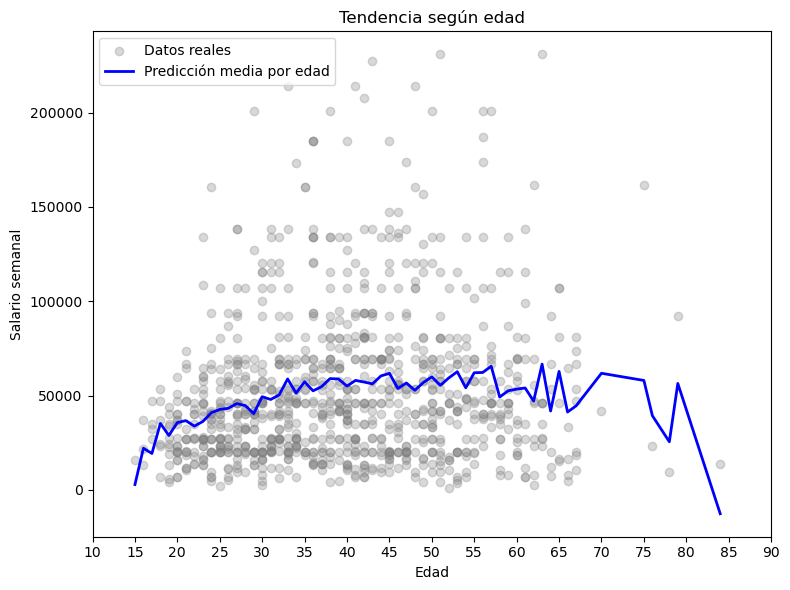

In [15]:
# Variables para el gráfico de estimado vs real
mejor_modelo = tabla_resultados.loc['RMSE'].idxmin()
print(f"\nEl modelo con mejor performance es: {mejor_modelo}")

test_ocupados = test_combined[
    (test_combined['ESTADO'] == 1) &
    (test_combined[['SALARIO_SEMANAL', 'CH06', 'EDAD2',
     'EDUC', 'PP04A', 'PP03D']].notnull().all(axis=1))
].copy()
test_ocupados['mujer'] = (test_ocupados['CH04'] == 2).astype(int)

# Sacamos el percentil 99, ya que los casos mas extremos no nos suman al análisis visual.
umbral = test_ocupados['SALARIO_SEMANAL'].quantile(0.99)
df_filtrado = test_ocupados[test_ocupados['SALARIO_SEMANAL'] <= umbral].copy(
)

vars = modelos[mejor_modelo]
x = df_filtrado[vars]
y_real = df_filtrado['SALARIO_SEMANAL']
edad = df_filtrado['CH06']
model5 = LinearRegression().fit(x, y_real)
y_pred = model5.predict(x)

# DF de predicción.
df_pred = pd.DataFrame({'edad': edad, 'pred': y_pred})

# Promedio de predicción para la línea del gráfico
df_prom = df_pred.groupby('edad', as_index=False)['pred'].mean()

# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(edad, y_real,
            alpha=0.3, color='grey', label='Datos reales')
plt.plot(df_prom['edad'], df_prom['pred'],
         color='blue', linewidth=2, label='Predicción media por edad')
plt.xlabel('Edad')
plt.xticks(np.arange(10, 91, 5))
plt.ylabel('Salario semanal')
plt.title('Tendencia según edad')
plt.legend()
plt.tight_layout()
plt.show()

### C. MÉTODOS DE CLASIFICACIÓN Y PERFORMANCE

### C5. Métodos LOGIT y KNN

235
107
RESULTADOS PARA AÑO: 2004
LOGIT
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1541
           1       1.00      0.87      0.93        61

    accuracy                           1.00      1602
   macro avg       1.00      0.93      0.96      1602
weighted avg       1.00      1.00      0.99      1602

Accuracy: 0.9950062421972534


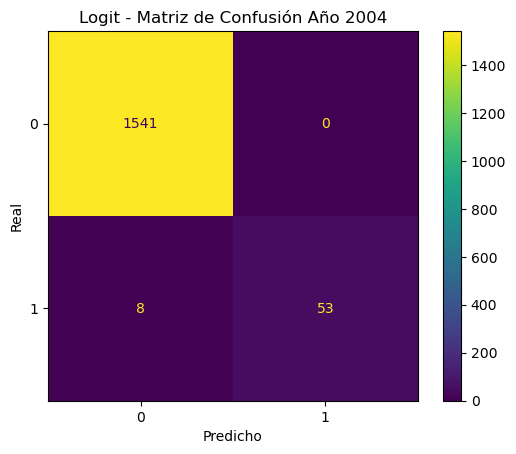

KNN con K=5
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1541
           1       1.00      0.16      0.28        61

    accuracy                           0.97      1602
   macro avg       0.98      0.58      0.63      1602
weighted avg       0.97      0.97      0.96      1602

Accuracy: 0.9681647940074907


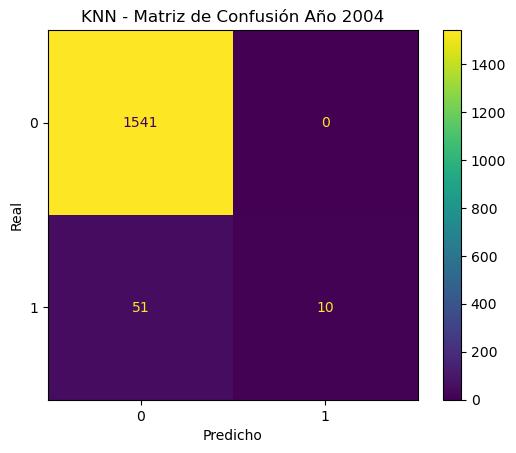

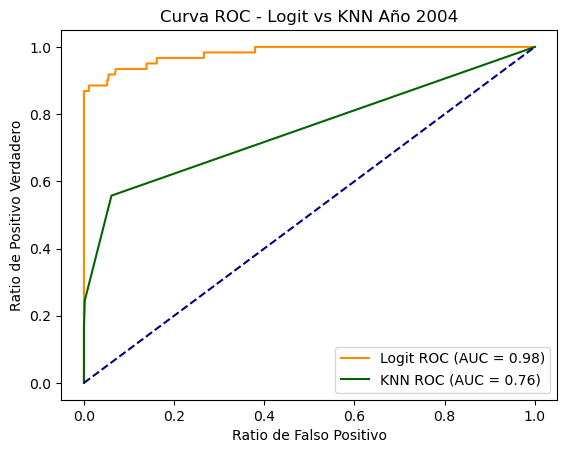

RESULTADOS PARA AÑO: 2024
LOGIT
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1316
           1       0.94      0.65      0.77        46

    accuracy                           0.99      1362
   macro avg       0.96      0.83      0.88      1362
weighted avg       0.99      0.99      0.99      1362

Accuracy: 0.986784140969163


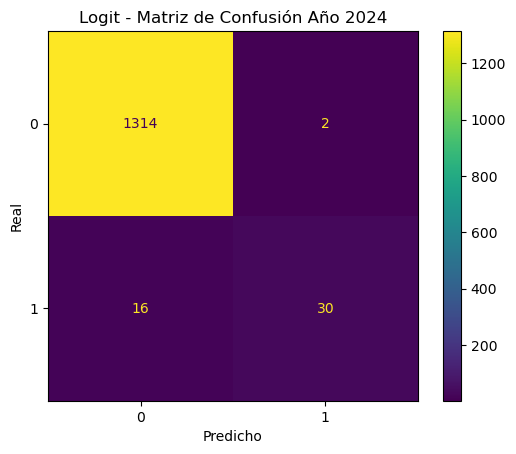

KNN con K=5
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1316
           1       1.00      0.15      0.26        46

    accuracy                           0.97      1362
   macro avg       0.99      0.58      0.62      1362
weighted avg       0.97      0.97      0.96      1362

Accuracy: 0.9713656387665198


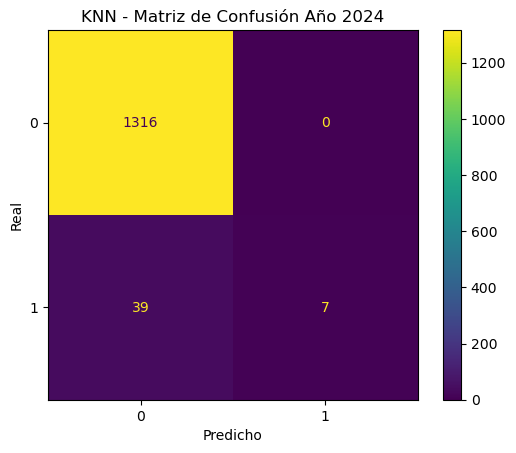

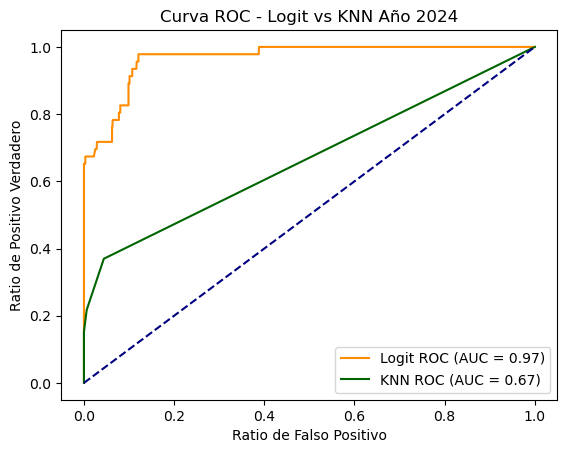


Resultados almacenados:

Año 2004:
Matriz de Confusión Logit:
[[1541    0]
 [   8   53]]
AUC Logit: 0.98
Matriz de Confusión KNN:
[[1541    0]
 [  51   10]]
AUC KNN: 0.76

Año 2024:
Matriz de Confusión Logit:
[[1314    2]
 [  16   30]]
AUC Logit: 0.97
Matriz de Confusión KNN:
[[1316    0]
 [  39    7]]
AUC KNN: 0.67


In [17]:
def c():
    train = pd.read_excel("train_combinado.xlsx").fillna(0)
    test = pd.read_excel("test_combinado.xlsx").fillna(0)

    variables = ['CH06', 'EDUC', 'CH08', 'CAT_OCUP', 'PP10D', 'NIVEL_ED']
    X_train = train[variables]
    y_train = train['target']
    X_test = test[variables]
    y_test = test['target']

    print(train['target'].sum())
    print(test['target'].sum())

    años = [2004, 2024]

    # Dictionaries to store results for each year
    resultados = {
        'logit_cm': {},
        'knn_cm': {},
        'logit_auc': {},
        'knn_auc': {}
    }

    for año in años:
        print(f"RESULTADOS PARA AÑO: {año}")

        # 3) Filtrar por año
        X_train = train[train['ANO4'] == año][variables]
        y_train = train[train['ANO4'] == año]['target']
        X_test = test[test['ANO4'] == año][variables]
        y_test = test[test['ANO4'] == año]['target']

        # 4) Regresión Logística
        logit = LogisticRegression(max_iter=1000)
        logit.fit(X_train, y_train)
        y_proba_logit = logit.predict_proba(X_test)[:, 1]
        y_pred_logit = (y_proba_logit > 0.5).astype(int)

        print("LOGIT")
        print(classification_report(y_test, y_pred_logit))
        print("Accuracy:", accuracy_score(y_test, y_pred_logit))

        # Matriz de confusión - Logit
        cm = confusion_matrix(y_test, y_pred_logit)
        resultados['logit_cm'][año] = cm
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"Logit - Matriz de Confusión Año {año}")
        plt.xlabel("Predicho")
        plt.ylabel("Real")
        plt.savefig(f'logit_confusion_{año}.png')
        plt.show()

        # 5) KNN (k=5)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_proba_knn = knn.predict_proba(X_test)[:, 1]
        y_pred_knn = knn.predict(X_test)

        print("KNN con K=5")
        print(classification_report(y_test, y_pred_knn))
        print("Accuracy:", accuracy_score(y_test, y_pred_knn))

        # Matriz de confusión - KNN
        cm2 = confusion_matrix(y_test, y_pred_knn)
        resultados['knn_cm'][año] = cm2
        ConfusionMatrixDisplay(cm2).plot()
        plt.title(f"KNN - Matriz de Confusión Año {año}")
        plt.xlabel("Predicho")
        plt.ylabel("Real")
        plt.savefig(f'knn_confusion_{año}.png')
        plt.show()

        # Combined ROC Curve for Logit and KNN
        # Calculate ROC and AUC for Logit
        fpr_logit, tpr_logit, _ = roc_curve(y_test, y_proba_logit)
        roc_auc_logit = roc_auc_score(y_test, y_proba_logit)
        resultados['logit_auc'][año] = roc_auc_logit

        # Calculate ROC and AUC for KNN
        fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
        roc_auc_knn = roc_auc_score(y_test, y_proba_knn)
        resultados['knn_auc'][año] = roc_auc_knn

        # Plot both ROC curves in the same figure
        plt.figure()
        plt.plot(fpr_logit, tpr_logit, color='darkorange', label=f'Logit ROC (AUC = {roc_auc_logit:.2f})')
        plt.plot(fpr_knn, tpr_knn, color='darkgreen', label=f'KNN ROC (AUC = {roc_auc_knn:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel("Ratio de Falso Positivo")
        plt.ylabel("Ratio de Positivo Verdadero")
        plt.title(f"Curva ROC - Logit vs KNN Año {año}")
        plt.legend(loc="lower right")
        plt.savefig(f'roc_comparison_{año}.png')
        plt.show()

    # Print stored results after the loop
    print("\nResultados almacenados:")
    for año in años:
        print(f"\nAño {año}:")
        print(f"Matriz de Confusión Logit:\n{resultados['logit_cm'][año]}")
        print(f"AUC Logit: {resultados['logit_auc'][año]:.2f}")
        print(f"Matriz de Confusión KNN:\n{resultados['knn_cm'][año]}")
        print(f"AUC KNN: {resultados['knn_auc'][año]:.2f}")

c()

In [19]:
variables = ['CH06', 'EDUC', 'CH08', 'CAT_OCUP', 'PP10D', 'NIVEL_ED']

train = pd.read_excel("train_combinado.xlsx").fillna(0)
rep = pd.read_excel("respondieron.xlsx").fillna(0)
norep = pd.read_excel("norespondieron.xlsx").fillna(0)

años = [2004, 2024]

for año in años:
    # Filtrar datos de entrenamiento por año
    train_año = train[train['ANO4'] == año]
    X_train = train_año[variables]
    y_train = train_año['target']

    # Ajustar modelo
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X_train, y_train)

    # Filtrar bases de predicción por año
    norep_año = norep[norep['ANO4'] == año]
    rep_año = rep[rep['ANO4'] == año]

    X_norep = norep_año[variables]
    X_rep = rep_año[variables]
    y_pred_norep = logit.predict(X_norep)
    y_pred_rep = logit.predict(X_rep)

    total_norep = len(y_pred_norep)
    desocupados_norep = sum(y_pred_norep)
    proporcion_norep = desocupados_norep / total_norep if total_norep > 0 else 0

    total_rep = len(y_pred_rep)
    desocupados_rep = sum(y_pred_rep)
    proporcion_rep = desocupados_rep / total_rep if total_rep > 0 else 0

    print(f"Año {año}:")
    print(f"Se predijeron {desocupados_norep} personas desocupadas sobre un total de {total_norep} en la base 'norespondieron'.")
    print(f"Proporción predicha de desocupados: {proporcion_norep:.2%}")
    print(f"Se predijeron {desocupados_rep} personas desocupadas sobre un total de {total_rep} en la base 'respondieron'.")
    print(f"Proporción predicha de desocupados: {proporcion_rep:.2%}")

Año 2004:
Se predijeron 0 personas desocupadas sobre un total de 5 en la base 'norespondieron'.
Proporción predicha de desocupados: 0.00%
Se predijeron 174 personas desocupadas sobre un total de 5338 en la base 'respondieron'.
Proporción predicha de desocupados: 3.26%
Año 2024:
Se predijeron 0 personas desocupadas sobre un total de 6 en la base 'norespondieron'.
Proporción predicha de desocupados: 0.00%
Se predijeron 97 personas desocupadas sobre un total de 4844 en la base 'respondieron'.
Proporción predicha de desocupados: 2.00%
